# Recommender System

**IMPORTANT**: This code is written with Python 3 and appropiate installation is required.  Below are the packages called on throughout the program. 

On Amazon, you are looking to purchase a new washing machine and while shopping, you see a recommendation for a dryer.  Why?  These appear from analyzing previous purchase and search data for the company creating a recommendation for relevant products.  

The Online Retail Data Sales data set from the UCI Machine Learning Repository contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.  This retail is having an issue moving products and wants to implement a recommendation system on it’s website allowing for ease of purchase for their customers.  

I will build a model that will give recommendations from previous transactions of the retail.  The company will be able to implement this model on their website that will allow for recommendations of relevant products to their shoppers. As a result, products will move on the website increasing the income of the retail. 


In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
import random

# Data Wrangling and Exploratory Data Analysis

Here, we are going to upload and clean the dataset we are using to recommend products to customers based on items purchased.

In [2]:
random.seed(1)
# Import data and setting the index to datetime
df=pd.read_csv('Online Retail.csv', parse_dates=True)
df.set_index("InvoiceDate", inplace = True)

We now observe the data to look to see if there are any patterns that can be immediately seen.

In [3]:
# Visual of the data
df.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
InvoiceDate,,,,,,,
12/1/10 8:26,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom
12/1/10 8:26,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom
12/1/10 8:26,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom
12/1/10 8:26,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom
12/1/10 8:26,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom


<font color='red'>
You can use a df.info() here
</font>

We now want to check and see if we have any missing values in our data.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 541909 entries, 12/1/10 8:26 to 12/9/11 12:50
Data columns (total 7 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
df.isna()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
InvoiceDate,,,,,,,
12/1/10 8:26,False,False,False,False,False,False,False
12/1/10 8:26,False,False,False,False,False,False,False
12/1/10 8:26,False,False,False,False,False,False,False
12/1/10 8:26,False,False,False,False,False,False,False
12/1/10 8:26,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
12/9/11 12:50,False,False,False,False,False,False,False
12/9/11 12:50,False,False,False,False,False,False,False
12/9/11 12:50,False,False,False,False,False,False,False


In [5]:
print(df.isna().sum())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


We see that we have missing values as the Customer ID and Description of the data. What we will do is drop the missing values.

In [6]:
df = df.dropna()

In [7]:
print(df.isna().sum())

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


We see that there are multiple transactions for a customer and the items are different. Since we are recommending items, let's see how many items would be ideal to recommend based on the average purchase per transaction.

In [8]:
avg_purc = df.groupby(['CustomerID','InvoiceDate']).Quantity.count()
avg_purc.describe()

count    22034.000000
mean        18.463692
std         23.931243
min          1.000000
25%          3.000000
50%         12.000000
75%         24.000000
max        543.000000
Name: Quantity, dtype: float64

In [9]:
avg_purc

CustomerID  InvoiceDate   
12346.0     1/18/11 10:01      1
            1/18/11 10:17      1
12347.0     1/26/11 14:30     29
            10/31/11 12:25    47
            12/7/10 14:57     31
                              ..
18283.0     7/14/11 13:20      1
            9/5/11 12:35      47
18287.0     10/12/11 10:23    38
            10/28/11 9:29      3
            5/22/11 10:39     29
Name: Quantity, Length: 22034, dtype: int64

We now want to look at how the data looks to see if we have any outliers and any other patterns that would be useful.

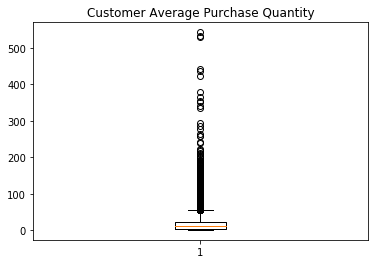

In [10]:
fig1, ax1 = plt.subplots()
ax1.set_title('Customer Average Purchase Quantity')
ax1.boxplot(avg_purc)
plt.show()

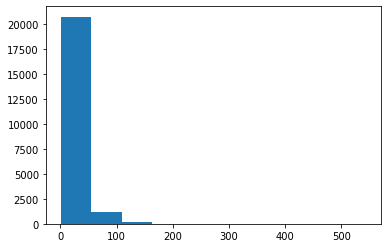

In [11]:
plt.hist(avg_purc)
plt.show()

We now want to remove the outliers to make sure our recommendations are as accurate as possible. We will utilize the data located between the 10% and 95% quartile markers.

In [12]:
lower_bound = 0.1
upper_bound = 0.95
bound = avg_purc.quantile([lower_bound,upper_bound])
bound

0.10     1.0
0.95    60.0
Name: Quantity, dtype: float64

In [13]:
avg_purc = avg_purc.loc[lambda df_dropped: (avg_purc > 0) & (avg_purc < 60)]
avg_purc.describe()

count    20903.000000
mean        14.554131
std         13.670369
min          1.000000
25%          3.000000
50%         11.000000
75%         22.000000
max         59.000000
Name: Quantity, dtype: float64

We now observe the data visually to see what we can tell from observing.

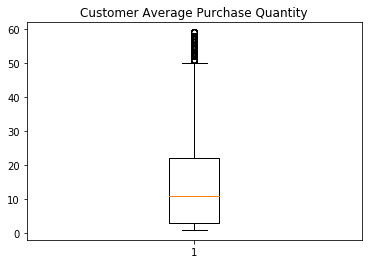

In [14]:
fig1, ax1 = plt.subplots()
ax1.set_title('Customer Average Purchase Quantity')
ax1.boxplot(avg_purc)
plt.show()

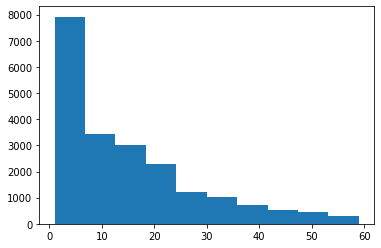

In [15]:
plt.hist(avg_purc)
plt.show()

Now we take a look at the summary of the numerical columns to see what we can gather. 

In [16]:
avg_purc.describe()

count    20903.000000
mean        14.554131
std         13.670369
min          1.000000
25%          3.000000
50%         11.000000
75%         22.000000
max         59.000000
Name: Quantity, dtype: float64

We see on average, 14 unique items are purchased during each transaction made by customers. Therefore, we will recommend 15 items to each customer.

In [17]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


We now look at the average cost of items for the business and the average number of items sold. We will then remove the outliers to obtain a more accurate recommendation for customers.

<font color='red'>
Do you want to use describe here?
</font>

In [18]:
avg_cost = df.groupby(['CustomerID','InvoiceDate']).UnitPrice.mean()
avg_cost

CustomerID  InvoiceDate   
12346.0     1/18/11 10:01     1.040000
            1/18/11 10:17     1.040000
12347.0     1/26/11 14:30     2.523103
            10/31/11 12:25    2.569362
            12/7/10 14:57     2.890000
                                ...   
18283.0     7/14/11 13:20     1.250000
            9/5/11 12:35      1.401915
18287.0     10/12/11 10:23    1.202632
            10/28/11 9:29     0.643333
            5/22/11 10:39     1.962759
Name: UnitPrice, Length: 22034, dtype: float64

<font color='red'>
Do you want to use describe here?
</font>

In [19]:
avg_quan = df.groupby(['CustomerID','InvoiceDate']).Quantity.mean()
avg_quan

CustomerID  InvoiceDate   
12346.0     1/18/11 10:01     74215.000000
            1/18/11 10:17    -74215.000000
12347.0     1/26/11 14:30        10.862069
            10/31/11 12:25       14.382979
            12/7/10 14:57        10.290323
                                  ...     
18283.0     7/14/11 13:20         2.000000
            9/5/11 12:35          2.021277
18287.0     10/12/11 10:23       26.052632
            10/28/11 9:29        36.000000
            5/22/11 10:39        16.827586
Name: Quantity, Length: 22034, dtype: float64

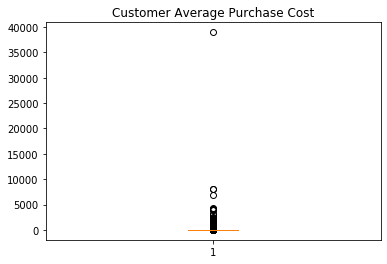

In [20]:
fig1, ax1 = plt.subplots()
ax1.set_title('Customer Average Purchase Cost')
ax1.boxplot(df['UnitPrice'])
plt.show()

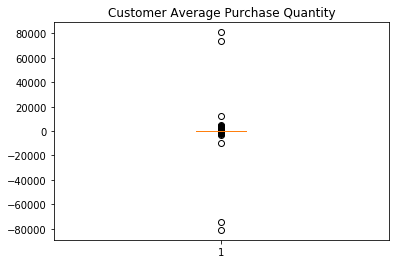

In [21]:
fig1, ax1 = plt.subplots()
ax1.set_title('Customer Average Purchase Quantity')
ax1.boxplot(df['Quantity'])
plt.show()

<font color='red'>
I would change your bin size for the next two graphs as it's not a really helpful graph the way it currently is
</font>

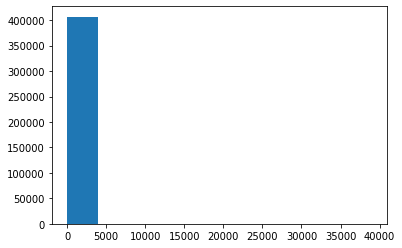

In [22]:
plt.hist(df['UnitPrice'])
plt.show()

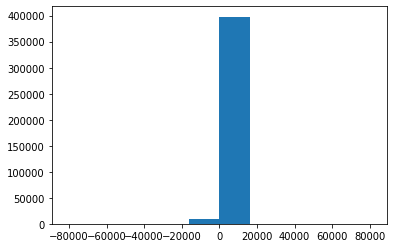

In [23]:
plt.hist(df['Quantity'])
plt.show()

In [24]:
bound2 = avg_cost.quantile([lower_bound,upper_bound])
bound2

0.10    1.420725
0.95    8.948375
Name: UnitPrice, dtype: float64

In [25]:
df = df.loc[lambda df_dropped: (df['UnitPrice'] > 0) & (df['UnitPrice'] < 8.948375)]

In [26]:
bound2 = avg_quan.quantile([lower_bound,upper_bound])
bound2

0.10    -1.333333
0.95    74.769151
Name: Quantity, dtype: float64

In [27]:
df = df.loc[lambda df_dropped: (df['Quantity'] > 0) & (df['Quantity'] < 74.769151)]

We now look and see if there are any outliers that would drastically impact the recommendation.

In [28]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,372094.000000,372094.000000,372094.000000
mean,9.016278,2.432360,15308.738625
std,10.750466,1.965455,1710.346572
min,1.000000,0.001000,12347.000000
25%,2.000000,1.250000,13982.000000
50%,6.000000,1.690000,15194.000000
75%,12.000000,2.950000,16810.000000
max,74.000000,8.870000,18287.000000


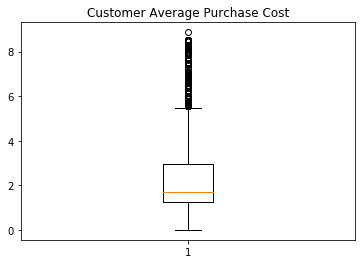

In [29]:
fig1, ax1 = plt.subplots()
ax1.set_title('Customer Average Purchase Cost')
ax1.boxplot(df['UnitPrice'])
plt.show()

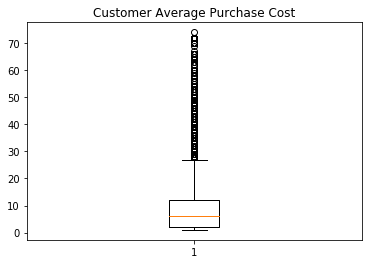

In [30]:
fig1, ax1 = plt.subplots()
ax1.set_title('Customer Average Purchase Cost')
ax1.boxplot(df['Quantity'])
plt.show()

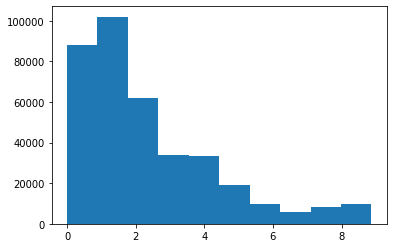

In [31]:
plt.hist(df['UnitPrice'])
plt.show()

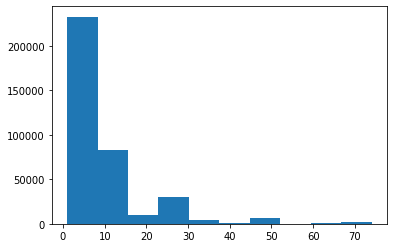

In [32]:
plt.hist(df['Quantity'])
plt.show()

In [21]:
df.InvoiceNo = df.InvoiceNo.str.extract('(\d+)', expand=False)
df.StockCode = df.StockCode.str.extract('(\d+)', expand=False)
df = df.dropna()
description = {i:j for h, i, j in df[['StockCode', 'Description']].itertuples()}
df = df.drop(['Description','Country'],axis=1)
df

,InvoiceNo,StockCode,Quantity,UnitPrice,CustomerID
InvoiceDate,,,,,
12/1/10 8:26,536365,85123,6,2.55,17850.0
12/1/10 8:26,536365,71053,6,3.39,17850.0
12/1/10 8:26,536365,84406,8,2.75,17850.0
12/1/10 8:26,536365,84029,6,3.39,17850.0
12/1/10 8:26,536365,84029,6,3.39,17850.0
...,...,...,...,...,...
12/9/11 12:50,581587,22613,12,0.85,12680.0
12/9/11 12:50,581587,22899,6,2.10,12680.0
12/9/11 12:50,581587,23254,4,4.15,12680.0


In [22]:
description

{'85123': 'CREAM HANGING HEART T-LIGHT HOLDER',
 '71053': 'WHITE MOROCCAN METAL LANTERN',
 '84406': 'CREAM CUPID HEARTS COAT HANGER',
 '84029': 'KNITTED UNION FLAG HOT WATER BOTTLE',
 '22752': 'SET 7 BABUSHKA NESTING BOXES',
 '21730': 'GLASS STAR FROSTED T-LIGHT HOLDER',
 '22633': 'HAND WARMER UNION JACK',
 '22632': 'HAND WARMER RED RETROSPOT',
 '84879': 'ASSORTED COLOUR BIRD ORNAMENT',
 '22745': "POPPY'S PLAYHOUSE BEDROOM ",
 '22748': "POPPY'S PLAYHOUSE KITCHEN",
 '22749': 'FELTCRAFT PRINCESS CHARLOTTE DOLL',
 '22310': 'IVORY KNITTED MUG COSY ',
 '84969': 'BOX OF 6 ASSORTED COLOUR TEASPOONS',
 '22623': 'BOX OF VINTAGE JIGSAW BLOCKS ',
 '22622': 'BOX OF VINTAGE ALPHABET BLOCKS',
 '21754': 'HOME BUILDING BLOCK WORD',
 '21755': 'LOVE BUILDING BLOCK WORD',
 '21777': 'RECIPE BOX WITH METAL HEART',
 '48187': 'DOORMAT NEW ENGLAND',
 '22960': 'JAM MAKING SET WITH JARS',
 '22913': 'RED COAT RACK PARIS FASHION',
 '22912': 'YELLOW COAT RACK PARIS FASHION',
 '22914': 'BLUE COAT RACK PARIS FASHION

# Recommender System

We want to make sure that we only have numeric input features to implement the KMeans clustering.

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 405043 entries, 12/1/10 8:26 to 12/9/11 12:50
Data columns (total 5 columns):
InvoiceNo     405043 non-null object
StockCode     405043 non-null object
Quantity      405043 non-null int64
UnitPrice     405043 non-null float64
CustomerID    405043 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 18.5+ MB


In [24]:
df.StockCode = df.StockCode.astype(int)
df.InvoiceNo = df.InvoiceNo.astype(int)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 405043 entries, 12/1/10 8:26 to 12/9/11 12:50
Data columns (total 5 columns):
InvoiceNo     405043 non-null int64
StockCode     405043 non-null int64
Quantity      405043 non-null int64
UnitPrice     405043 non-null float64
CustomerID    405043 non-null float64
dtypes: float64(2), int64(3)
memory usage: 18.5+ MB


We now perform the Elbow Method to predict how many clusters/categories our data can be separated into. We do so by finding the sum of squared distances of samples to their closest cluster, inertia, center while we iterate over a range of values for **k**. 

In [26]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df)
    Sum_of_squared_distances.append(km.inertia_)

We now plot the results and observe the optimal value for **k** which is located at the "elbow", or the point after which the inertia start decreasing in a linear fashion.

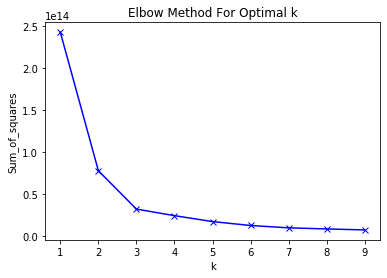

In [27]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squares')
plt.title('Elbow Method For Optimal k')
plt.show()

We can see that the elbow is located at $ k=3 $. We now perform KMeans on the data where the number of clusters is 3. 

In [28]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

We now extract the labels and add them to the dataframe.

In [33]:
labels = list(kmeans.labels_)
df['labels']=labels
df

,InvoiceNo,StockCode,Quantity,UnitPrice,CustomerID,labels
InvoiceDate,,,,,,
12/1/10 8:26,536365,85123,6,2.55,17850.0,1
12/1/10 8:26,536365,71053,6,3.39,17850.0,1
12/1/10 8:26,536365,84406,8,2.75,17850.0,1
12/1/10 8:26,536365,84029,6,3.39,17850.0,1
12/1/10 8:26,536365,84029,6,3.39,17850.0,1
...,...,...,...,...,...,...
12/9/11 12:50,581587,22613,12,0.85,12680.0,0
12/9/11 12:50,581587,22899,6,2.10,12680.0,0
12/9/11 12:50,581587,23254,4,4.15,12680.0,0


We now create a pivot table where the columns are the unique items of the data and the rows are the customers that purchased those particular items. We do this to obtain a correlation matrix that will give a measure of closeness in commonality.  

In [34]:
CustomerLabels = df.pivot_table(index='CustomerID', columns='StockCode',values='labels')
CustomerLabels

StockCode,2,10002,10080,10120,10123,10124,10125,10133,10135,11001,...,90202,90204,90205,90206,90208,90209,90210,90211,90212,90214
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12347.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12348.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12349.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12350.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18281.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18282.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
corrMatrix = CustomerLabels.corr()
corrMatrix.head()

StockCode,2,10002,10080,10120,10123,10124,10125,10133,10135,11001,...,90202,90204,90205,90206,90208,90209,90210,90211,90212,90214
StockCode,,,,,,,,,,,,,,,,,,,,,
2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10080,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10120,NaN,NaN,NaN,1.0,NaN,NaN,1.0,0.27735,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We now can ask for a recommendation. We input the StockCode into the search box then drop the missing values. We will then obtain all of the products that have some correlation to the product we are seeking a recommendation for.

<font color='red'>
I would put this in a function like get_recomendation(StockCode) that returns the results you want
</font>

In [36]:
StockLabel = CustomerLabels.loc[12347.0].dropna()
StockLabel

StockCode
16008    2.0
17021    2.0
20665    2.0
20719    0.5
20780    2.0
        ... 
84997    1.0
85116    1.0
85167    1.0
85178    1.0
85232    1.0
Name: 12347.0, Length: 99, dtype: float64

We now create the recommendation by looking for similar items in the correlation matrix. We when drop the missing values and sort the items based on most common to least common. We are then going to take the top 10 items and recommend them to the customer.

In [37]:
RecStock = pd.Series()
for i in range(0,len(StockLabel)):
    sim = corrMatrix[StockLabel.index[i]].dropna()
    RecStock = RecStock.append(sim)
    
RecStock.sort_values(inplace=True,ascending=False)
recommendation = RecStock.to_frame(name='label').head(15)
recommendation

,label
22285,1.0
22530,1.0
21471,1.0
22095,1.0
22810,1.0
22124,1.0
22136,1.0
22589,1.0
22254,1.0
22778,1.0
